In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torchvision
import torch.nn as nn
import torchmetrics
from torchvision import transforms

import torchvision.models as models
from torch.utils.data import DataLoader, Dataset,random_split
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.metrics import classification_report


In [2]:
# 预处理
aug=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(), #ToTensor可以将PIL图像或Numpy数组转换成FloatTensor，并将图像的像素密度值压缩到[0.,1.]区间。
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), #标准化,训练时候更快的收敛 RGB三个通道
    ])#增强完已经转成np array（ToTensor()） 后面batch=next(iter(train_loader));就不报错了

dataset=torchvision.datasets.ImageFolder(r'H:\0. videos\Bilibili\[医学AI-图像分类] COVID二分类问题-Pytorch源码\前处理\Binary',transform=aug)

train_set, val_set =random_split(dataset,
                            [int(np.floor(len(dataset)*0.75)),int(np.ceil(len(dataset)*0.25))])

#data loader expect the input as tensor not as numpy or PIL
train_loader = DataLoader(dataset,shuffle=True,num_workers=0,batch_size=8) # num_workers=0 is enough for this small dataset
batch = next(iter(train_loader));

# 2. Test Model, Loss function and Metric

In [3]:
resnet18 = models.resnet18()  # torchvision中有resnet18

## TorchVision加载ResNet18

https://zhuanlan.zhihu.com/p/421629812

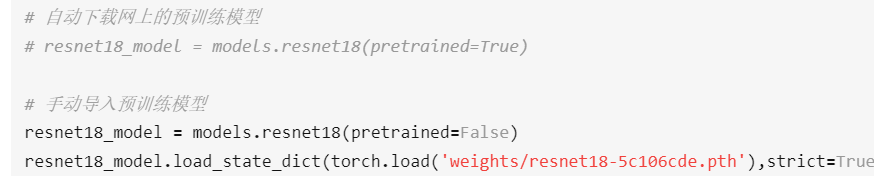

In [4]:
resnet18 # 深度残差网络 深度=18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## ResNet网络结构分析

https://zhuanlan.zhihu.com/p/79378841

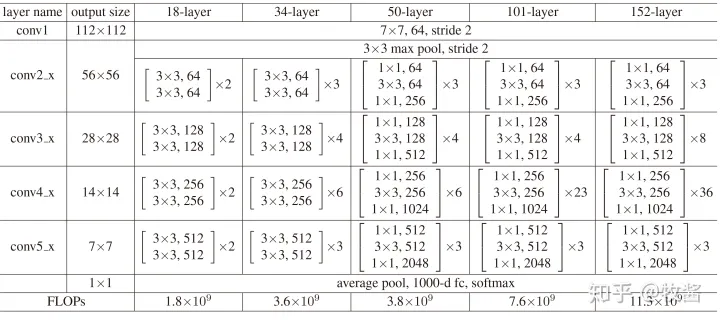

## 你必须要知道CNN模型：ResNet

https://zhuanlan.zhihu.com/p/31852747

In [5]:
#改一下最后全连接层的结构
# 原 (fc): Linear(in_features=512, out_features=1000, bias=True)

resnet18.fc=nn.Sequential(                    # fc= fully-connected layer
    nn.Linear(resnet18.fc.in_features,224),   # 512 pass on to 224 neuron
    nn.ReLU(),
    nn.Linear(224,1)  # 224 pass on to 1 neuron 只是分类，输出0或者1
    )

resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 关于激活函数

神经网络中使用激活函数来加入非线性因素，提高模型的表达能力。

如果不用激活函数，在这种情况下每一层输出都是上层输入的线性函数。

激活函数ReLU的理解与总结https://zhuanlan.zhihu.com/p/376520223#:~:text=%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B0ReLU%E7%9A%84%E7%90%86%E8%A7%A3%E4%B8%8E%E6%80%BB%E7%BB%93%201%20%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B0%E7%9A%84%E4%BD%9C%E7%94%A8%20%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E4%B8%AD%E4%BD%BF%E7%94%A8%E6%BF%80%E6%B4%BB%E5%87%BD%E6%95%B0%E6%9D%A5%E5%8A%A0%E5%85%A5%E9%9D%9E%E7%BA%BF%E6%80%A7%E5%9B%A0%E7%B4%A0%EF%BC%8C%E6%8F%90%E9%AB%98%E6%A8%A1%E5%9E%8B%E7%9A%84%E8%A1%A8%E8%BE%BE%E8%83%BD%E5%8A%9B%E3%80%82%20...%202%20ReLU%20%28Rectified,8%20%E4%BC%98%E7%82%B9%3A%201%29%20%E4%B8%8D%E4%BC%9A%E8%BF%87%E6%8B%9F%E5%90%88%20%28saturate%29%20...%20More%20items

ReLU激活函数https://zhuanlan.zhihu.com/p/428448728



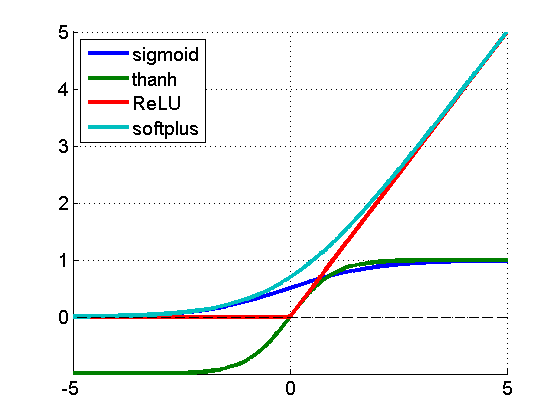

In [6]:
batch[0] # 8 个图片
batch[1] # is a label

tensor([0, 1, 0, 1, 1, 1, 1, 1])

In [7]:
pred=resnet18(batch[0])
print(pred.shape)
pred

torch.Size([8, 1])


tensor([[-0.4443],
        [-0.4023],
        [-0.4469],
        [-0.3470],
        [-0.5146],
        [-0.4428],
        [-0.3968],
        [-0.4025]], grad_fn=<AddmmBackward0>)

In [8]:
criterion=nn.BCEWithLogitsLoss()             # loss function 计算loss
criterion(pred.flatten(),batch[1].float())

tensor(0.8167, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [9]:
accuracy = torchmetrics.Accuracy(task='binary') # 计算accuracy
accuracy(pred.flatten(),batch[1])

tensor(0.2500)

### 创建一个类 OurModel

In [10]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        
        # model architecute  
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc=nn.Sequential(
            nn.Linear(self.resnet18.fc.in_features,224),
            nn.ReLU(),
            nn.Linear(224,1)
            )
        
        # augmentation
        self.aug=transforms.Compose([
                    transforms.Resize(size=(224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                    ])
        
        #parameters
        self.lr=1e-4
        self.batch_size=224
        self.numworker=1
        self.acc = torchmetrics.Accuracy(task = 'binary') # metric
        self.criterion=nn.BCEWithLogitsLoss() # loss function
        #list to store loss and accuracy
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        
        #load data        
        # self.dataset=torchvision.datasets.ImageFolder('Binary',transform=self.aug)
        dataroot = r'H:\0. videos\Bilibili\[医学AI-图像分类] COVID二分类问题-Pytorch源码\前处理\Binary'
        dataset=torchvision.datasets.ImageFolder(dataroot,transform=self.aug)
        
        #split data
        self.train_set, self.val_set =random_split(dataset,
                            [int(np.floor(len(dataset)*0.75)),int(np.ceil(len(dataset)*0.25))],
                                                  generator=torch.Generator().manual_seed(42))
    def forward(self,x):
        x=self.resnet18(x)
        return x

    
    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        return opt
    
    def train_dataloader(self):#load train 
        return DataLoader(self.train_set,shuffle=True,num_workers=self.numworker,batch_size=self.batch_size)

    def training_step(self,batch,batch_idx):
        image,label=batch
        pred = self(image)#pass images to model
        loss=self.criterion(pred.flatten(),label.float()) #calculate loss
        acc=self.acc(pred.flatten(),label)#calculate accuracy
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        #average loss and accuracy in all batches of train data
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)

        
    def val_dataloader(self):
        ds=DataLoader(self.val_set,shuffle=False,num_workers=self.numworker,batch_size=self.batch_size)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        pred=self(image)
        loss=self.criterion(pred.flatten(),label.float())
        acc=self.acc(pred.flatten(),label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)


### 实例化 类 OurModel

In [11]:
# 类的实例化 （即根据类来创建一个或多个对象）
model = OurModel()

C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ziyif\miniconda3\envs\pytorch_env1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
model

OurModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r